In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import math

# **Dataset**

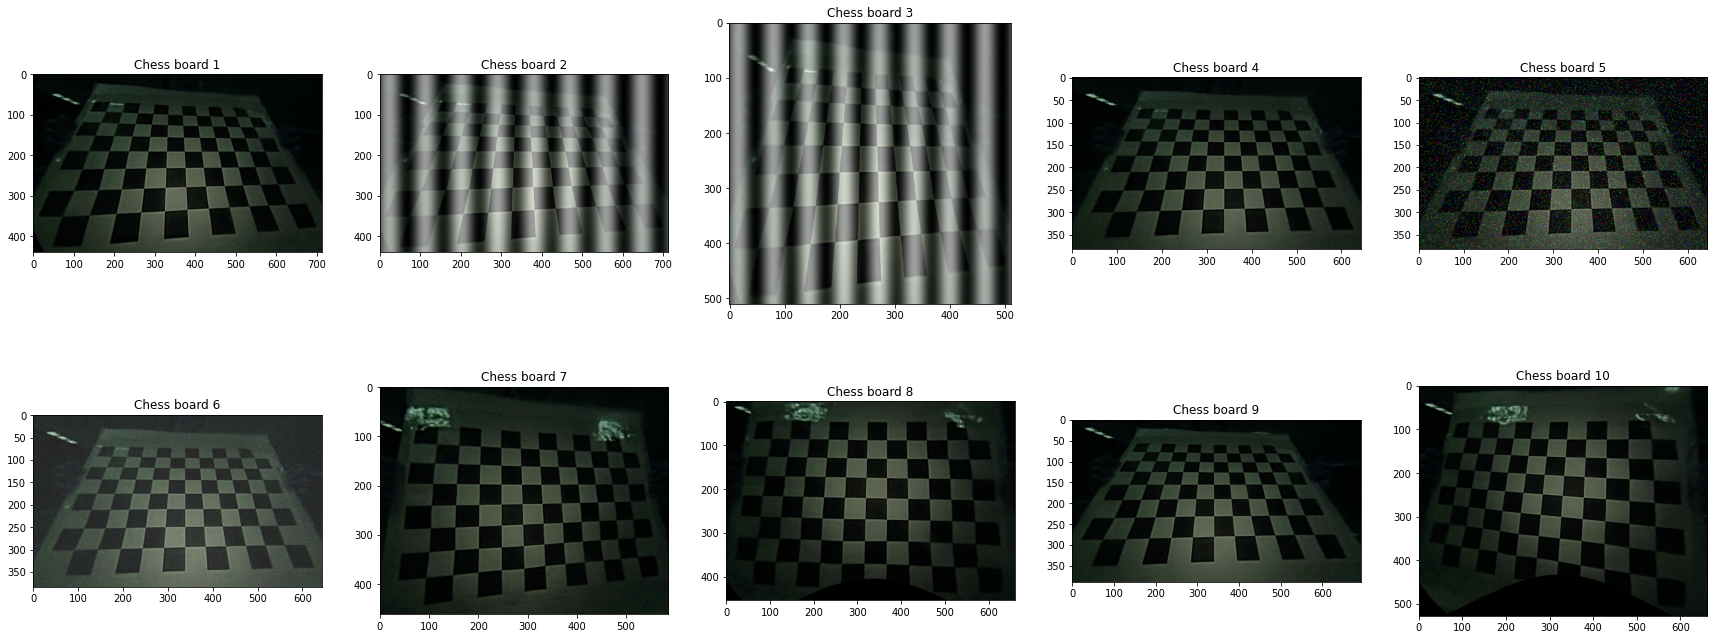

In [ ]:
fig = plt.figure(figsize=(30, 30))
for i in range (1, 11):
  img = cv.imread('/content/chess{}.png'.format(i))
  ax = fig.add_subplot(5, 5, i)
  ax.imshow(img, cmap='gray')
  ax.title.set_text('Chess board {}'.format(i))

# **Data Preprocess**

# Remove Sinus Noise

In [ ]:
def remove_sinus_noise(img):
  w = img.shape[1]
  h = img.shape[0]

  # Output is a 3D complex array. 1st channel real and 2nd imaginary
  # For fft in opencv input image needs to be converted to float32
  dft = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)

  # Rearranges a Fourier transform X by shifting the zero-frequency
  # component to the center of the array.
  # Otherwise it starts at the tope left corenr of the image (array)
  dft_shift = np.fft.fftshift(dft)

  # Magnitude of the function is 20.log(abs(f))
  # For values that are 0 we may end up with indeterminate values for log.
  # So we can add 1 to the array to avoid seeing a warning.
  magnitude_spectrum = 20 * \
      np.log(cv.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

  # Circular HPF mask, center circle is 0, remaining all ones
  # Can be used for edge detection because low frequencies at center are blocked
  # and only high frequencies are allowed. Edges are high frequency components.
  # Amplifies noise.

  rows, cols = img.shape

  mask = np.zeros((rows, cols, 2), np.uint8)

  rectangle = cv.rectangle(mask, (int(w/2)-8, int(h/2)), (int(w/2)-7, int(h/2)+1), 255, -1)
  rectangle = cv.rectangle(mask, (int(w/2)+8, int(h/2)), (int(w/2)+9, int(h/2)+1), 255, -1)
  mask = cv.bitwise_not(mask)

  # apply mask and inverse DFT
  fshift = dft_shift * mask

  fshift_mask_mag = 2000 * \
      np.log(cv.magnitude(fshift[:, :, 0], fshift[:, :, 1]))

  f_ishift = np.fft.ifftshift(fshift)
  img_back = cv.idft(f_ishift)
  img_back = cv.magnitude(img_back[:, :, 0], img_back[:, :, 1])

  return img_back

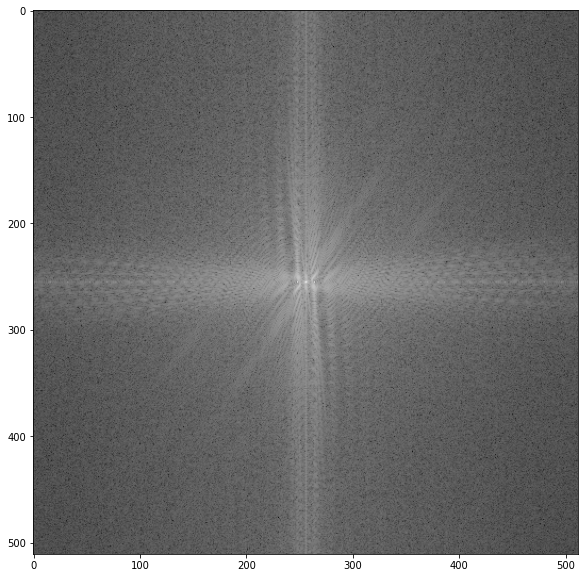

In [ ]:
img = cv.imread('/content/chess3.png', 0)
w = img.shape[1]
h = img.shape[0]
dft = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20 * \
      np.log(cv.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
plt.figure(figsize=(10, 10))
plt.imshow(magnitude_spectrum, cmap='gray')

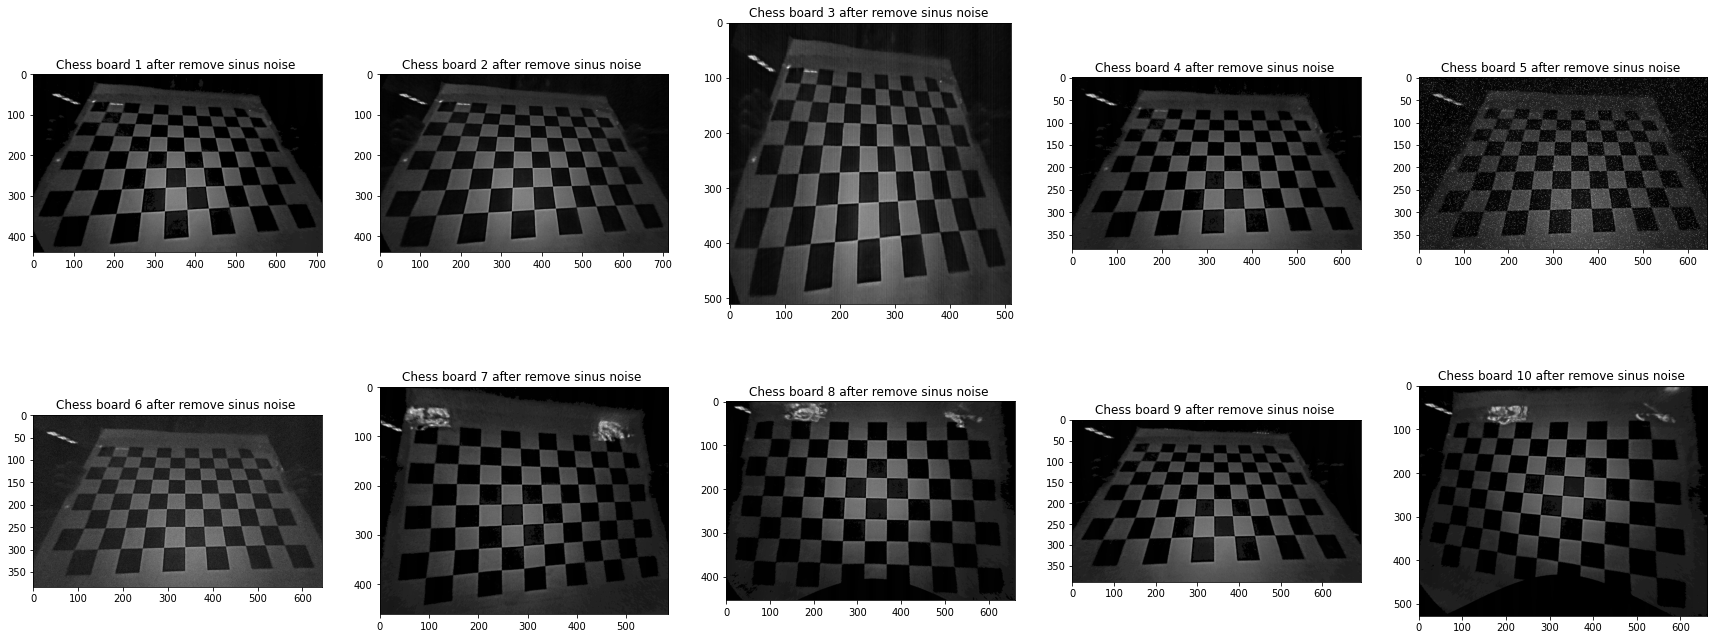

In [ ]:
fig = plt.figure(figsize=(30, 30))
for i in range (1, 11):
  img = cv.imread('/content/chess{}.png'.format(i), 0)
  result = remove_sinus_noise(img)
  ax = fig.add_subplot(5, 5, i)
  ax.imshow(result, cmap='gray')
  ax.title.set_text('Chess board {} after remove sinus noise '.format(i))

# Remove salt-pepper, enhance contrast and brightness

In [ ]:
def enhance(img):
  norm = cv.normalize(src=img, dst=None, alpha=0,
                           beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
  blur = cv.medianBlur(norm, 3)
  enhance = cv.convertScaleAbs(blur, alpha=3, beta=3)

  return enhance

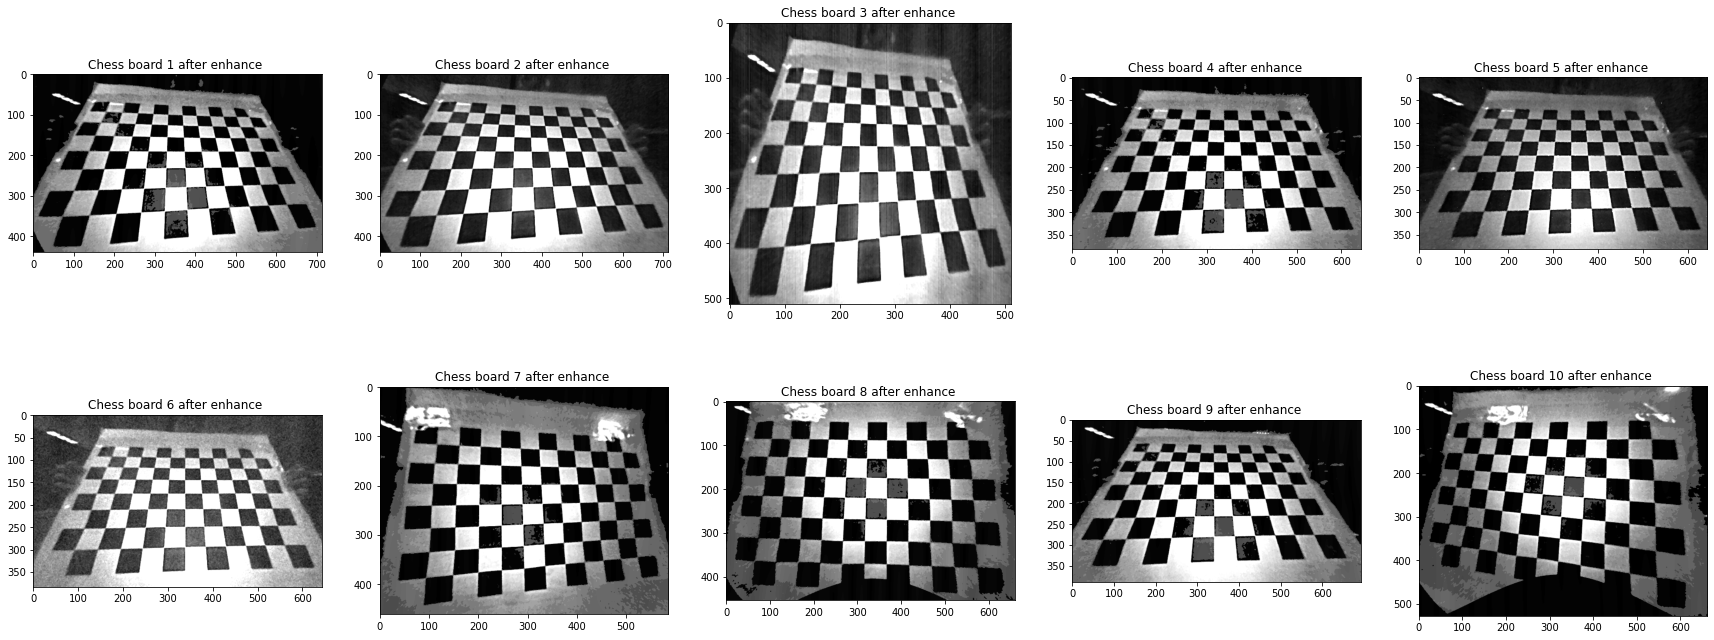

In [ ]:
fig = plt.figure(figsize=(30, 30))
for i in range (1, 11):
  img = cv.imread('/content/chess{}.png'.format(i), 0)
  result = remove_sinus_noise(img)
  result = enhance(result)
  ax = fig.add_subplot(5, 5, i)
  ax.imshow(result, cmap='gray')
  ax.title.set_text('Chess board {} after enhance '.format(i))

# **Corner Detection**

# Remove outer contour

In [ ]:
def remove_outer_contour(img):
    thresh = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,151,5)
    contours, _ = cv.findContours(thresh, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        sorted_contours= sorted(contours, key=cv.contourArea, reverse= True)
        max_contour = sorted_contours[0]
        if cv.contourArea(max_contour) > 4000:
            mask = np.zeros_like(thresh)
            cv.drawContours(mask, [max_contour], -1, (1), -1)
            nthresh = np.zeros_like(thresh)
            nthresh.fill(255)
            thresh = nthresh * np.where(mask == 1, 0, 1) + thresh * mask

    contours, _ = cv.findContours(thresh, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
    for c in contours:
        if cv.contourArea(c) < 200:
            cv.drawContours(thresh.astype(np.uint8), [c], -1, (255, 255, 255), -1)

    return thresh.astype(np.uint8)

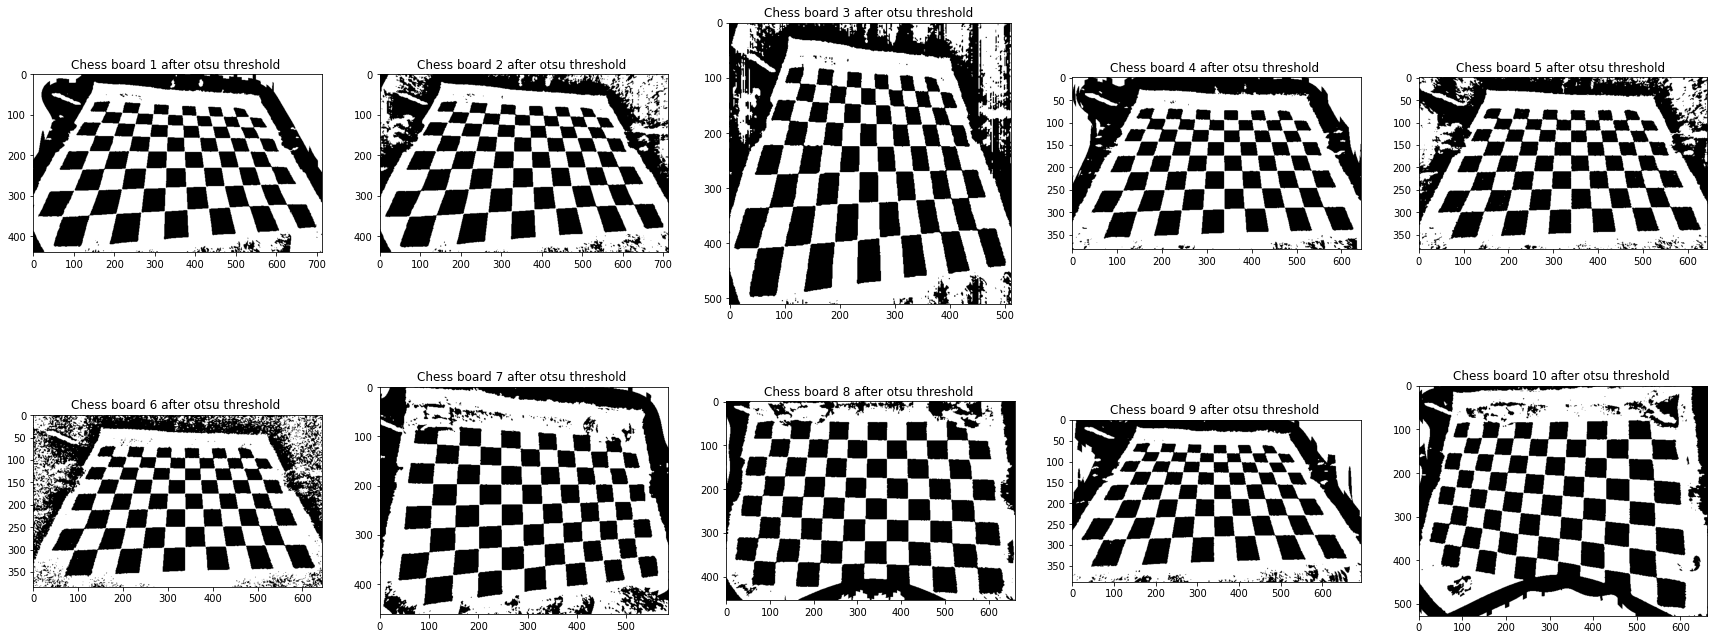

In [ ]:
fig = plt.figure(figsize=(30, 30))
for i in range (1, 11):
  img = cv.imread('/content/chess{}.png'.format(i), 0)
  result = remove_sinus_noise(img)
  result = enhance(result)
  thresh = cv.adaptiveThreshold(result,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,151,5)
  
  ax = fig.add_subplot(5, 5, i)
  ax.imshow(thresh, cmap='gray')
  ax.title.set_text('Chess board {} after otsu threshold '.format(i))

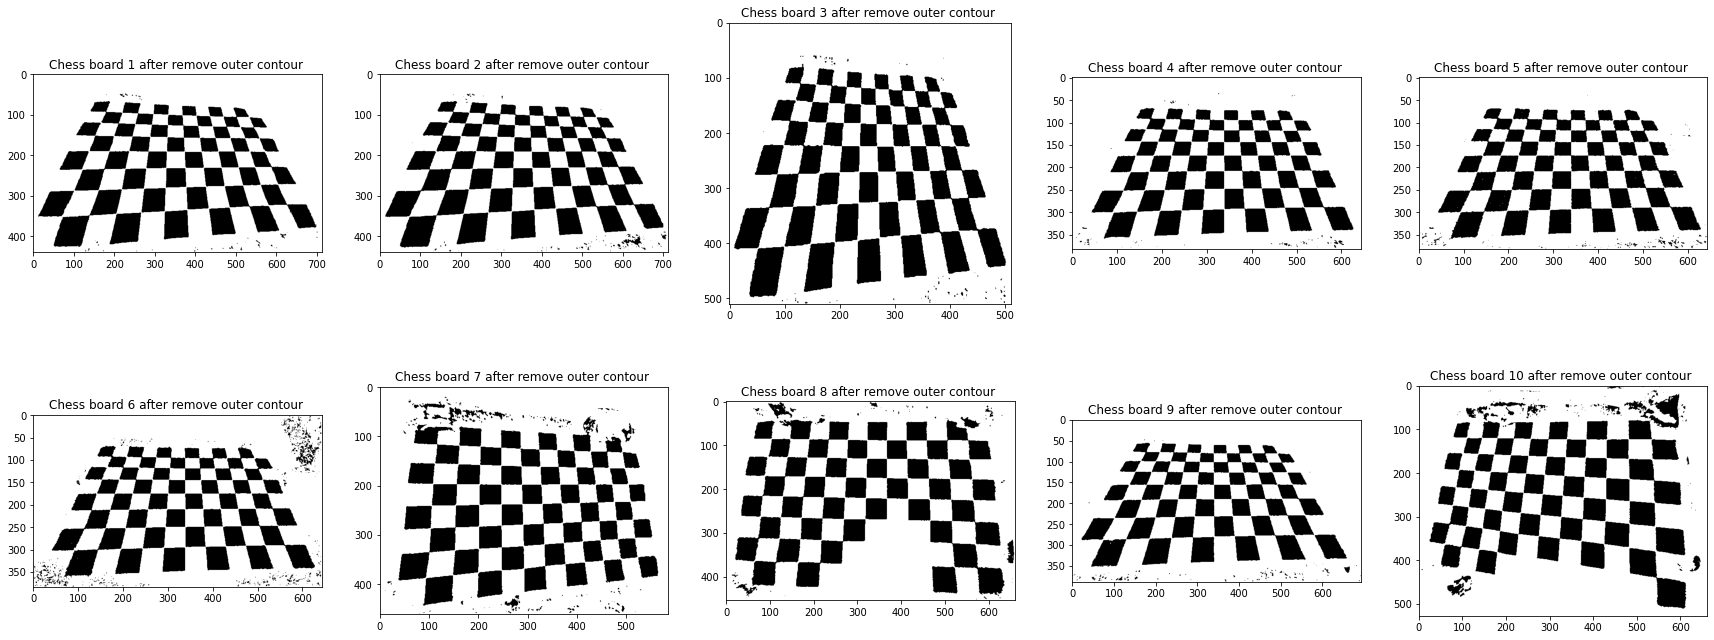

In [ ]:
fig = plt.figure(figsize=(30, 30))
for i in range (1, 11):
  img = cv.imread('/content/chess{}.png'.format(i), 0)
  result = remove_sinus_noise(img)
  result = enhance(result)
  result = remove_outer_contour(result)
  
  ax = fig.add_subplot(5, 5, i)
  ax.imshow(result, cmap='gray')
  ax.title.set_text('Chess board {} after remove outer contour '.format(i))

# Remove small contour area in the outer

In [ ]:
def remove_small_area(img):
  contours, _ = cv.findContours(img, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
  for c in contours:
    if cv.contourArea(c) < 100:
      cv.drawContours(img, [c], -1, (255, 255, 255), -1)

  return img

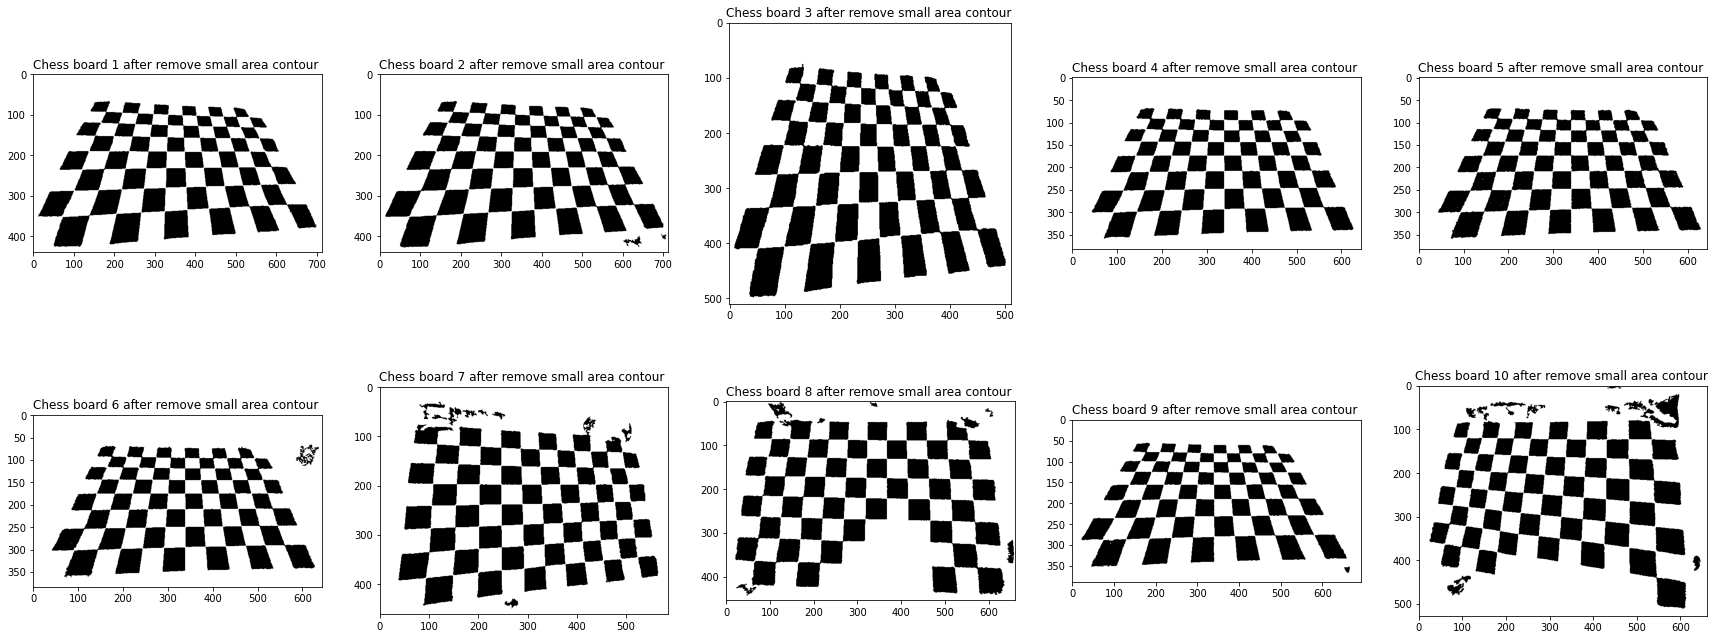

In [ ]:
fig = plt.figure(figsize=(30, 30))
for i in range (1, 11):
  img = cv.imread('/content/chess{}.png'.format(i), 0)
  result = remove_sinus_noise(img)
  result = enhance(result)
  result = remove_outer_contour(result)
  result = remove_small_area(result)
  
  ax = fig.add_subplot(5, 5, i)
  ax.imshow(result, cmap='gray')
  ax.title.set_text('Chess board {} after remove small area contour '.format(i))

# Detect Corner

In [ ]:
def show_points(image, pts, show_label = False):
    print('Number of points: ', len(pts))
    plt.figure(figsize=(12,12))
    img_copy = np.copy(image)
    pts = pts.tolist()
    for index, p in enumerate(pts):
        y, x = p 
        cv.circle(img_copy, (x, y), 3, (0, 255, 0), -1)
        if (show_label == True):
            cv.putText(img_copy, str(index), (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.6,  (0, 0, 255), 1)

    plt.imshow(img_copy[...,[2,1,0]])
    plt.show()

In [ ]:
def detect_corner(img): 
    corners = cv.goodFeaturesToTrack(img, 500,0.01, 20)
    corners = np.intp(corners)
    points = np.array([[i.ravel()[1], i.ravel()[0]] for i in corners])
    
    return points

Number of points:  198


<Figure size 2160x2160 with 0 Axes>

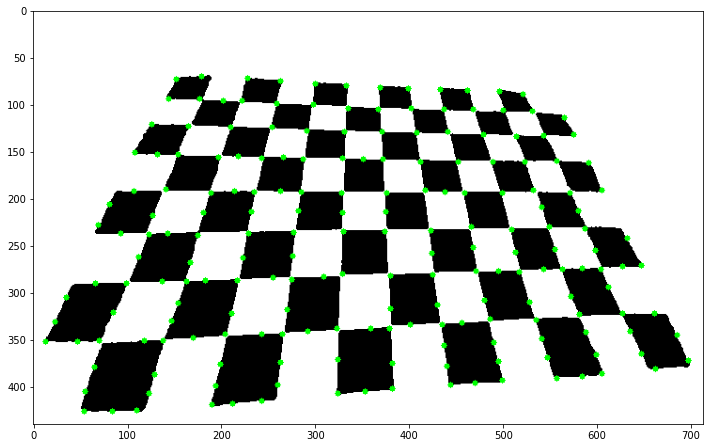

Number of points:  199


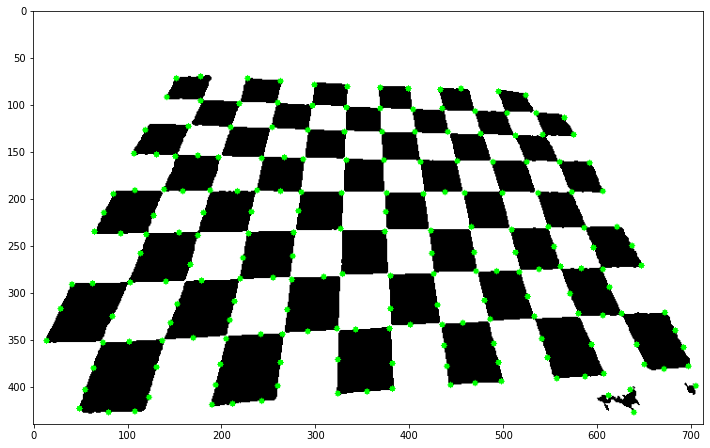

Number of points:  181


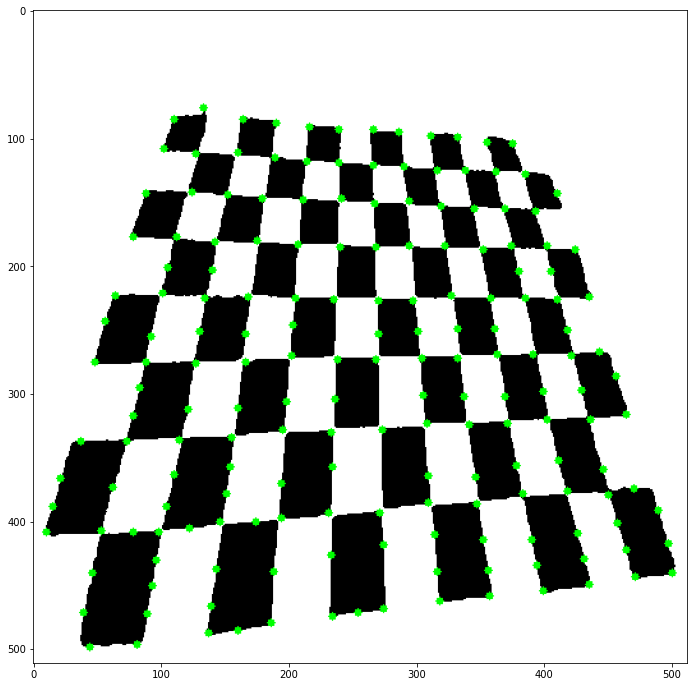

Number of points:  150


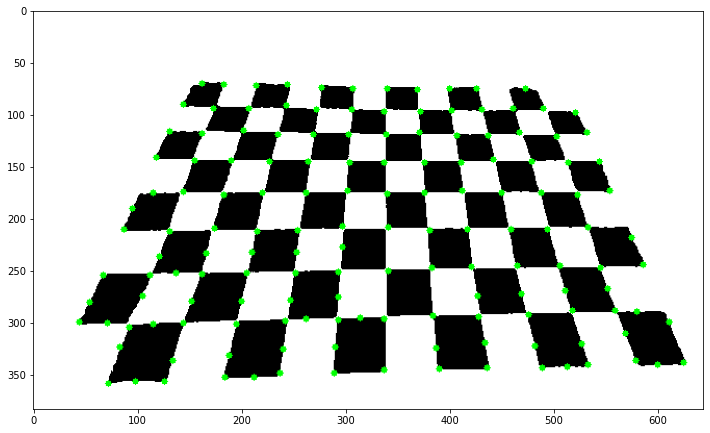

Number of points:  160


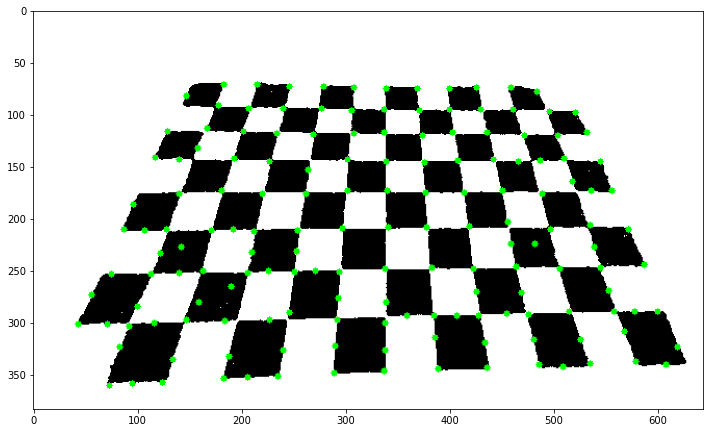

Number of points:  156


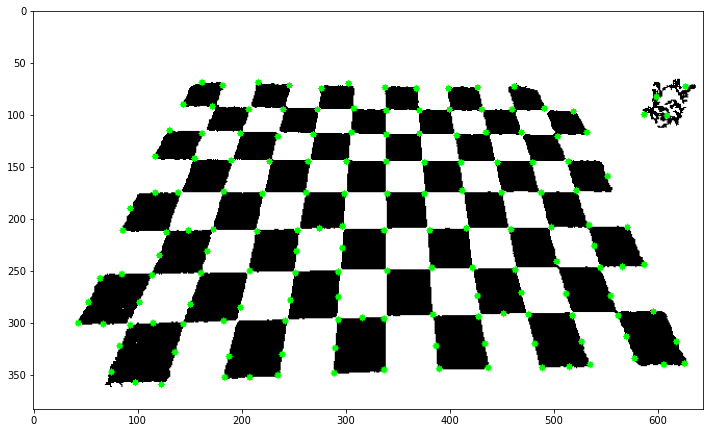

Number of points:  169


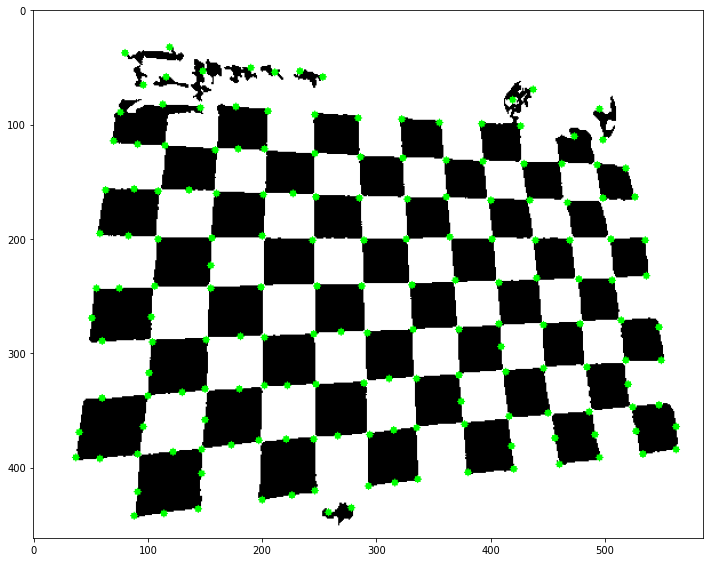

Number of points:  207


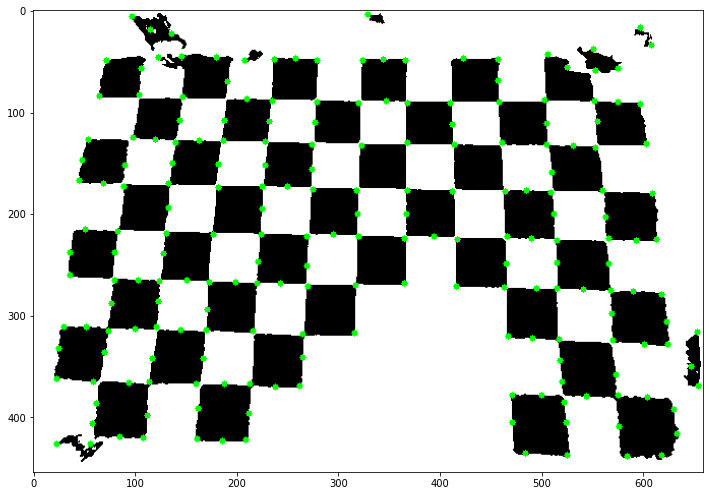

Number of points:  164


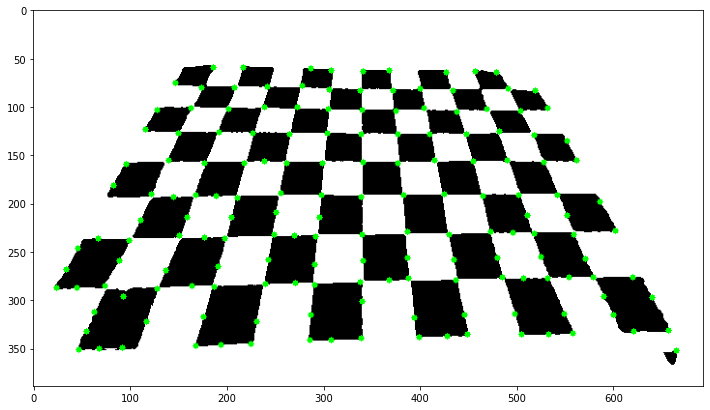

Number of points:  247


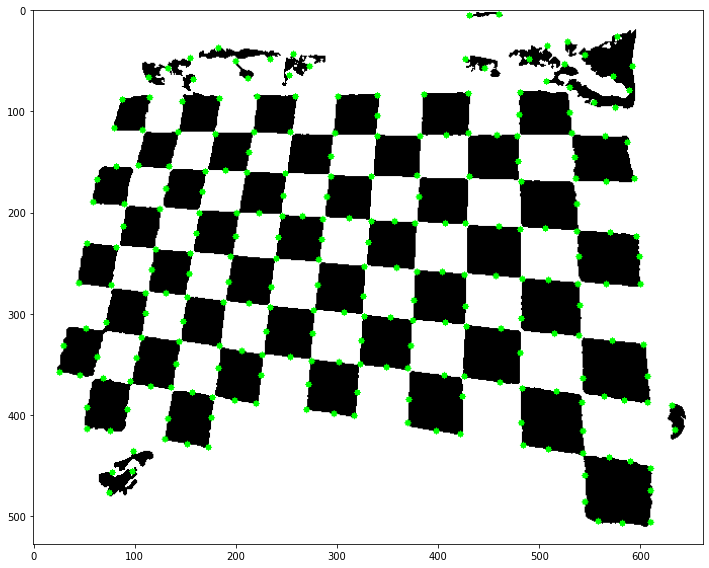

In [ ]:
fig = plt.figure(figsize=(30, 30))
for i in range (1, 11):
  img = cv.imread('/content/chess{}.png'.format(i), 0)
  result = remove_sinus_noise(img)
  result = enhance(result)
  result = remove_outer_contour(result)
  result = remove_small_area(result)
  corners = detect_corner(result)
  show_points(np.stack((result, result, result), axis=-1), corners, show_label=False)
  

# Filter Corner

In [ ]:
class SquareResponseFilter:
    def __init__(self, size=8, half_smoothing_window_size=4):
        self.size = size
        self.half_smoothing_window_size = half_smoothing_window_size

    def _get_square_response(self, image, point):
        """Iterate through a square centered at keypoint and get a response."""
        assert len(image.shape) == 2, 'Image must be binarized.'
        k = self.size
        # top-left, bottom-right
        tl, br = point - k, point + k
        # top-right, bottom-left
        tr = np.array([point[0] - k, point[1] + k])
        bl = np.array([point[0] + k, point[1] - k])

        response = []
        # take all point in the horizonal line from tl -> tr
        for j in range(tl[1], tr[1]):
            response.append(image[tl[0], j])
        # take all point in the vertical line from tr -> br
        for i in range(tr[0], br[0]):
            response.append(image[i, tr[1]])
        # take all point in the horizonal line from br -> bl
        for j in range(br[1], bl[1], -1):
            response.append(image[br[0], j])
        # take all point in the vertical line from bl -> tl    
        for i in range(bl[0], tl[0], -1):
            response.append(image[i, bl[1]])

        return response

    @staticmethod
    def _count_segments(response):
        prev = response[0]
        cnt = 1
        for cur in response[1:]:
            if cur != prev:
                cnt += 1
            prev = cur
        return cnt

    def filter(self, binarized, corners):
        kept = []
        for corner in corners:
            try:
                response = self._get_square_response(binarized, corner)
            except IndexError:  # If a point to too close to the border
                continue
            if self._count_segments(response) in [4, 5]:
                kept.append(corner)
        return np.array(kept)

In [ ]:
def corner_filter(img, points):
  square_response_filter = SquareResponseFilter()
  filter_points = square_response_filter.filter(img, points)

  return filter_points

Number of points:  78


<Figure size 2160x2160 with 0 Axes>

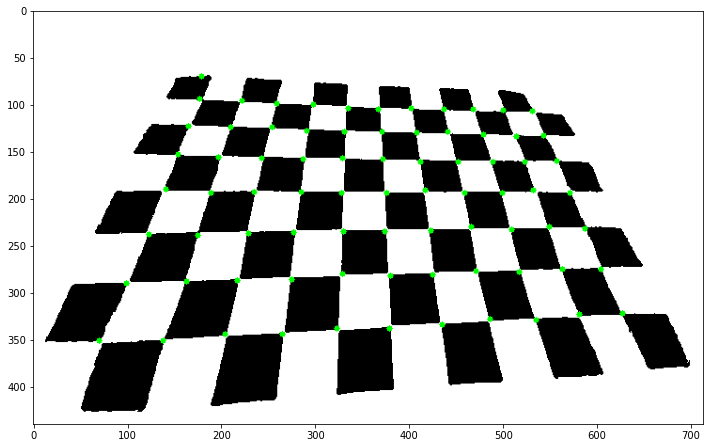

Number of points:  78


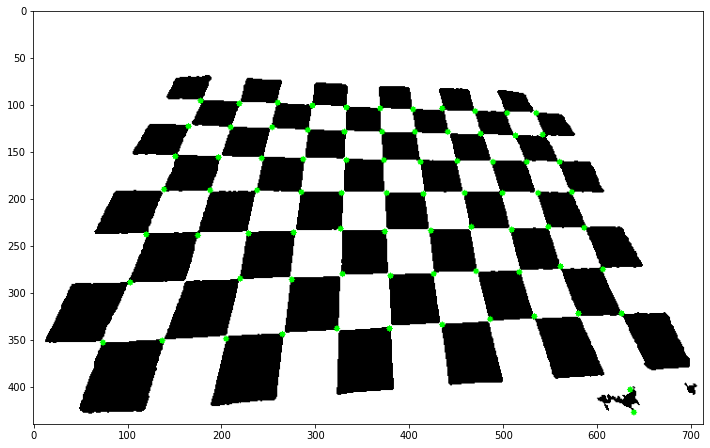

Number of points:  77


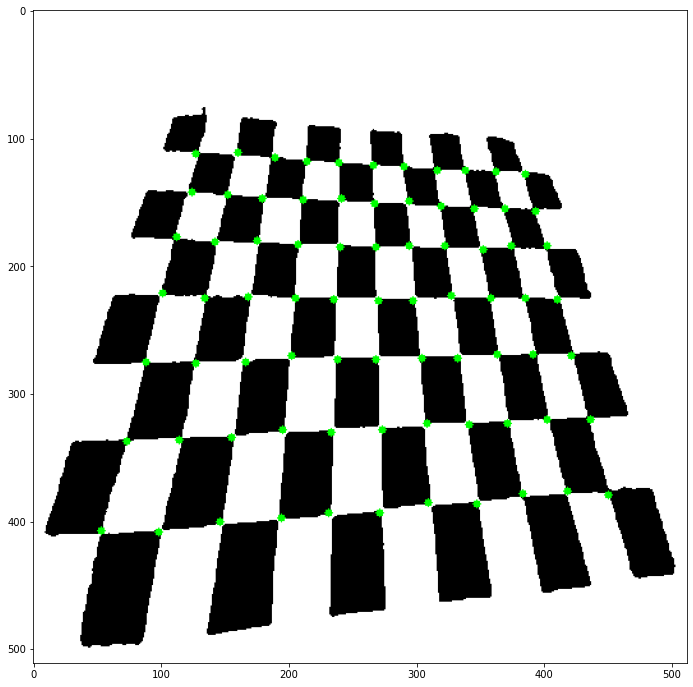

Number of points:  77


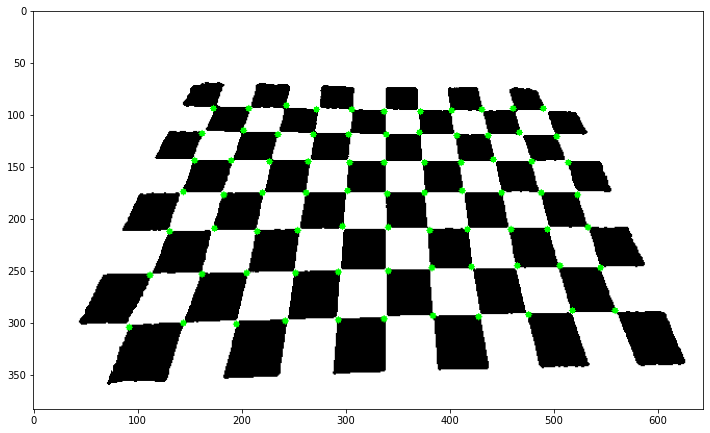

Number of points:  73


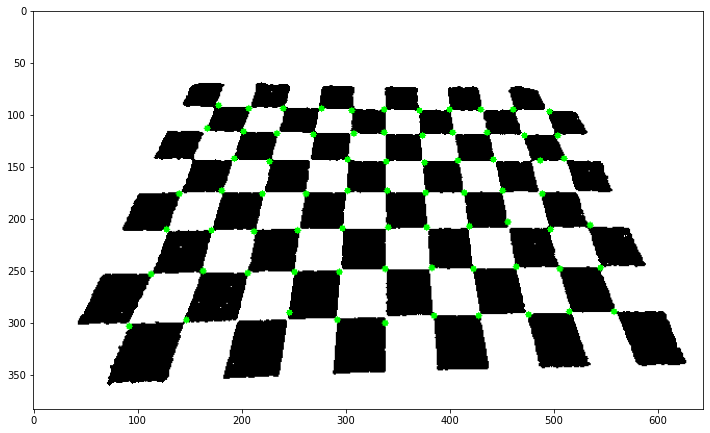

Number of points:  77


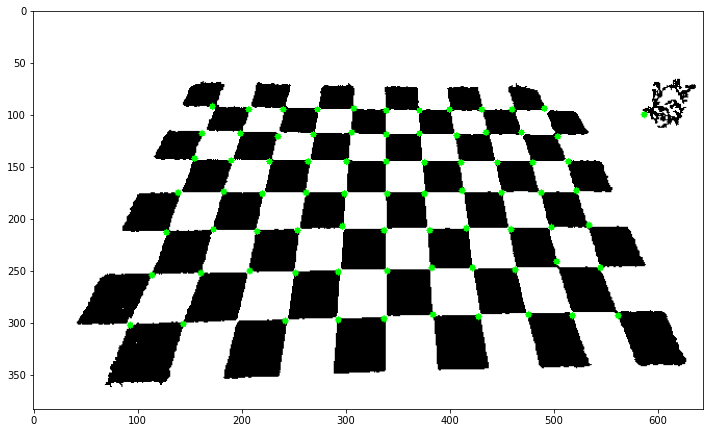

Number of points:  81


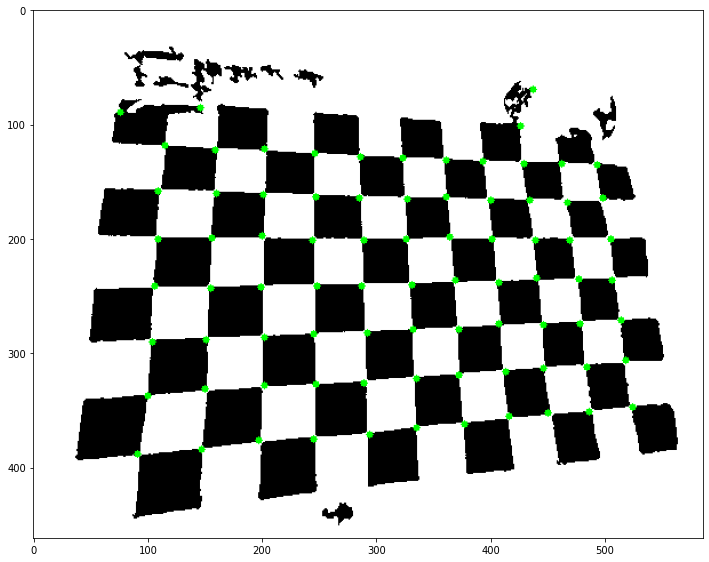

Number of points:  68


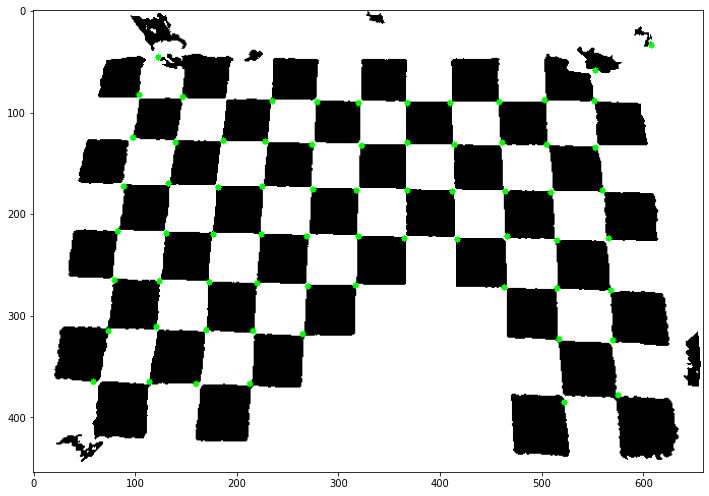

Number of points:  77


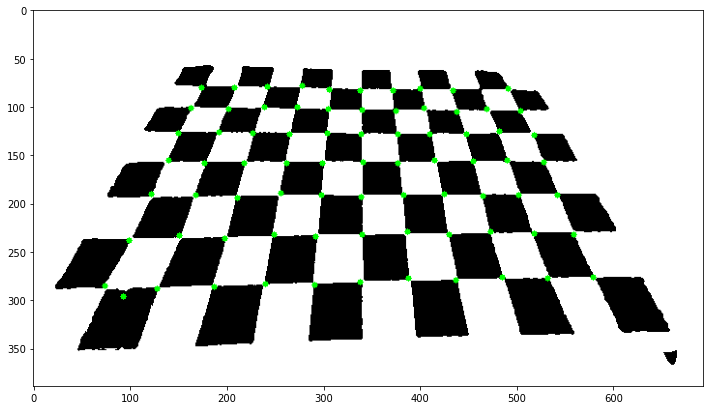

Number of points:  81


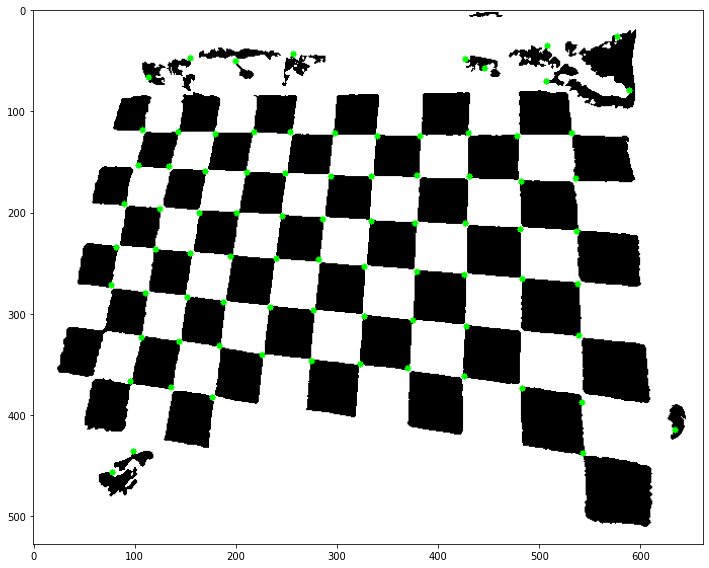

In [ ]:
filter_points_in_images = []
fig = plt.figure(figsize=(30, 30))
for i in range (1, 11):
  img = cv.imread('/content/chess{}.png'.format(i), 0)
  result = remove_sinus_noise(img)
  result = enhance(result)
  result = remove_outer_contour(result)
  result = remove_small_area(result)
  corners = detect_corner(result)
  corners_filter = corner_filter(result, corners)
  show_points(np.stack((result, result, result), axis=-1), corners_filter, show_label=False)
  filter_points_in_images.append(corners_filter.tolist())

# **Determine Chessboard**

In [ ]:
# Find distance and angle between 2 points
def cal_horizontal_angle_and_distance(pt1, pt2):
    horizontal_length = np.abs(pt1[1] - pt2[1])
    vertical_length = np.abs(pt1[0] - pt2[0])
    angle = np.arctan(vertical_length / (horizontal_length + 0.00000000000000000000000000000001))
    distance = np.sqrt(horizontal_length * horizontal_length + vertical_length * vertical_length)
    return angle, distance

# Find the nearest left and right index points of a point satisfy distance and angle condition
def find_horizontal_adjacent_points(this_pt, all_pt, max_angle = np.pi / 10, radius = 65):
    left = []
    right = []
    this_pt_index = -1
    for pt in all_pt:
        if (pt[1] == this_pt[1] and pt[0] == this_pt[0]):
            this_pt_index = all_pt.index(pt)
            continue
        angle, distance = cal_horizontal_angle_and_distance(pt, this_pt)
        if (angle < max_angle and distance < radius):
            if (pt[1] < this_pt[1]):
                left.append(all_pt.index(pt))
            else:
                right.append(all_pt.index(pt))
    
    def condition(pt_index):
        angle, distance = cal_horizontal_angle_and_distance(all_pt[pt_index], this_pt)
        return distance
    
    left.sort(key=condition) 
    right.sort(key=condition) 
    
    res_left = None
    res_right = None
    if (len(left) != 0):
        res_left = left[0]
    if (len(right) != 0):
        res_right = right[0]

    return [res_left, res_right]

In [ ]:
def find_line(pt_index, lines, left = False, right = False):
    if pt_index is None:
        return None
    for line in lines: 
        if line[-1] == pt_index and left == True: 
            return line
        if line[0] == pt_index and right == True: 
            return line
        
def find_adjacent_pair_points_on_a_line(pt_index, lines):
    left = None
    right = None
    for line in lines: 
        if pt_index in line:
            position_of_point_on_line = line.index(pt_index)
            if position_of_point_on_line > 0:
                left = line[position_of_point_on_line - 1]
            if position_of_point_on_line != (len(line) - 1):
                right = line[position_of_point_on_line + 1]
    return left, right

In [ ]:
def construct_line_array(filter_points):
    horizontal_lines = []
    for pt_index, pt in enumerate(filter_points):
        # Find index of pair left right of a point in a line
        lpt_index, rpt_index = find_adjacent_pair_points_on_a_line(pt_index, horizontal_lines)
        if lpt_index is not None and rpt_index is not None: 
            continue
        if lpt_index is not None and rpt_index is None:
            rpt_index = find_horizontal_adjacent_points(pt, all_pt)[1]
            if rpt_index != None:
                line = find_line(pt_index, horizontal_lines, left = True)
                right_line = find_line(rpt_index, horizontal_lines, right = True)
                if right_line is None:
                    line.append(rpt_index)
                else:
                    line.extend(right_line)
                    horizontal_lines.remove(right_line)    
        
        if rpt_index is not None and lpt_index is None:
            lpt_index = find_horizontal_adjacent_points(pt, all_pt)[0]
            if lpt_index != None:
                line = find_line(pt_index, horizontal_lines, right = True)
                left_line = find_line(lpt_index, horizontal_lines, left = True)
                if left_line is None:
                    line.insert(0, lpt_index)
                else:
                    left_line.extend(line)
                    horizontal_lines.remove(line)
                    
        if rpt_index is None and lpt_index is None:
            # Left right index of nearest point
            lpt_index, rpt_index = find_horizontal_adjacent_points(pt, all_pt)
            left_line = find_line(lpt_index, horizontal_lines, left = True)
            right_line = find_line(rpt_index, horizontal_lines, right = True)
            if lpt_index is not None: 
                if left_line is not None:
                    left_line.append(pt_index)
                    if rpt_index is not None:
                        if right_line is not None:
                            left_line.extend(right_line)
                            horizontal_lines.remove(right_line)
                        else:
                            left_line.append(rpt_index)
                else:
                    if rpt_index is not None:
                        if right_line is not None:
                            right_line.insert(0, pt_index)
                            right_line.insert(0, lpt_index)
                        else:
                            horizontal_lines.append([lpt_index, pt_index, rpt_index])
                    else:
                        horizontal_lines.append([lpt_index, pt_index])
            else:
                if rpt_index is not None:
                    if right_line is not None:
                        right_line.insert(0, pt_index)
                    else:
                        horizontal_lines.append([pt_index, rpt_index])
    return horizontal_lines

In [ ]:
def measure_chessboard_size(horizontal_lines_array):
    average_length = sum(len(line) for line in horizontal_lines_array) / len(horizontal_lines_array)
    filtered_lines = [line for line in horizontal_lines_array if abs(len(line) - average_length) <= 3]
    max_length = 0
    for line in filtered_lines:
      tmp = len(line)
      if tmp > max_length:
        max_length = tmp
    # max_length = max(len(line) for line in filtered_lines)
    return [max_length + 1, len(filtered_lines) + 1]

In [ ]:
horizontal_lines_array_in_images = []
for all_pt in filter_points_in_images:
    temp  = construct_line_array(all_pt)
    horizontal_lines_array_in_images.append(temp)
    print("horizontal line", temp, "\n")

horizontal line [[60, 61, 0, 59, 6, 26, 58, 11], [24, 31, 3, 23, 68, 67, 22, 15, 8, 30, 21], [4, 71, 45, 46, 25, 47, 48, 17, 49, 18, 38], [66, 5, 29, 35, 65, 2, 10, 7, 20, 28, 14], [9, 64, 34, 63, 36, 1, 32, 33, 62, 13, 19], [41, 27, 43, 42, 16, 44, 72, 73, 12], [69, 74, 50, 51, 53, 52, 54, 57, 55, 70, 56]] 

horizontal line [[46, 40, 26, 1, 65, 7, 63, 64, 33, 32, 48], [36, 29, 35, 17, 70, 2, 27, 9, 22, 21, 34], [71, 41, 28, 6, 47, 5, 4, 10, 3, 37, 23], [11, 78, 57, 58, 31, 59, 60, 62, 61, 39, 74], [13, 69, 43, 68, 67, 16, 38, 15, 66, 12, 49], [45, 75, 24, 54, 30, 55, 25, 20, 56, 73, 8], [44, 42], [76, 50, 52, 51, 19, 53, 72, 77, 14]] 

horizontal line [[0, 55, 74, 34, 57, 56, 59, 58, 24, 40, 60], [14, 75, 12, 2, 63, 18, 61, 35, 1, 27, 62], [41, 6, 70, 5, 69, 17, 68, 4, 37, 25, 16], [71, 20, 38, 11, 10, 9, 8, 32, 7, 26, 31], [15, 22, 67, 21, 65, 3, 30, 36, 64, 19, 66], [23, 39, 50, 52, 51, 33, 29, 53, 54, 76, 13], [72, 42, 43, 28, 45, 44, 47, 46, 73, 49, 48]] 

horizontal line [[20, 59

In [ ]:
for i in range (len(horizontal_lines_array_in_images)):
    chessboard_size = measure_chessboard_size(horizontal_lines_array_in_images[i])
    print('Chessboard size of image '+ str(i+1) + ': '  + str(chessboard_size[0]) + 'x'+ str(chessboard_size[1]))

Chessboard size of image 1: 12x8
Chessboard size of image 2: 12x8
Chessboard size of image 3: 12x8
Chessboard size of image 4: 12x8
Chessboard size of image 5: 12x8
Chessboard size of image 6: 12x8
Chessboard size of image 7: 12x8
Chessboard size of image 8: 7x3
Chessboard size of image 9: 12x8
Chessboard size of image 10: 11x5
